# ABXplore Data Quality Analysis

In [3]:
#importing libraries
import pandas as pd
import sqlite3
import numpy as np

import matplotlib.pyplot as plt

# Leads Table Analysis
Understanding lead data quality issues

### Load Data from Database

In [41]:
# Connect to database

conn = sqlite3.connect('../db/abxplore.db')
df = pd.read_sql("SELECT * FROM leads", conn)
df_ce = pd.read_sql_query("SELECT * FROM contact_events", conn)
df_fs = pd.read_sql_query("SELECT * FROM funnel_stages", conn)
df_out = pd.read_sql_query("SELECT * FROM outcomes", conn)
conn.close()

# View structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lead_id         10000 non-null  object 
 1   company_name    10000 non-null  object 
 2   contact_email   10000 non-null  object 
 3   contact_phone   8442 non-null   object 
 4   industry        10000 non-null  object 
 5   region          9500 non-null   object 
 6   source_channel  10000 non-null  object 
 7   company_size    10000 non-null  object 
 8   created_at      10000 non-null  object 
 9   annual_revenue  10000 non-null  float64
 10  group           10000 non-null  object 
 11  assigned_at     10000 non-null  object 
dtypes: float64(1), object(11)
memory usage: 937.6+ KB


✅ Observation:

- `contact_phone` has missing values.
- `region` has approximately 500 null or missing entries.
- All columns are stored as `object` data type, except `annual_revenue` which is `float64`.

#### Preview of `leads` Table

In [3]:
df.head(5)

,lead_id,company_name,contact_email,contact_phone,industry,region,source_channel,company_size,created_at,annual_revenue,group,assigned_at
0,b94961e5-d68b-41e0-851f-b4cada81764c,Lewis LLC,daviscolin@example.com,None,Retail,North America,Referral,Small,2024-05-03 04:35:40,6.512543e+05,control,2024-05-03
1,35f453bd-0c01-400a-bc8e-4bd4239e388e,"Montgomery, Hensley and Ray",williamsjeremy@example.com,731-564-7525,Manufacturing,None,Webinar,Small,2024-04-17 00:14:30,3.878259e+05,control,2024-04-17
2,d883e192-e052-4795-9762-96933e36ed49,"Watts, Robinson and Nguyen",perezantonio@example.com,(541)639-5376x7242,Technology,Asia Pacific,Cold Email,Medium,2024-05-17 12:01:46,1.190717e+06,control,2024-05-17
3,fbdc9213-9346-4d02-a591-191ed53cfd18,"Spencer, Chapman and Smith",perezrebecca@example.com,983-547-3829,Manufacturing,Europe,Cold Email,Small,2024-05-03 09:37:46,3.021554e+05,control,2024-05-03
4,11e9ab89-7533-4e3c-b6fb-8f7ef8185b1c,Baxter Inc,jmorton@example.org,5808132677,Retail,Latin America,Cold Email,Small,2024-04-11 16:03:19,3.767124e+06,control,2024-04-11


#### Initial Observations

- We can see inconsistencies in the `contact_phone` field such as:
  - Missing values
  - Mixed formatting (e.g., `x123`, `ext456`, parentheses, dots)
- These patterns indicate a need for cleaning and standardization.
- `annual_revenue` column has many decimal places — we will round to 2 decimal places later.

In [4]:
df.describe()

,annual_revenue
count,1.000000e+04
mean,7.660627e+06
std,5.028222e+07
min,-5.000000e+05
25%,8.778870e+05
50%,2.102949e+06
75%,5.310916e+06
max,1.552851e+09


From the `.describe()` output of the `annual_revenue` column:

- **Min Value:** -500,000  Indicates **invalid negative revenue**
- **Max Value:** 1.55 Billion → **Extremely high**, likely unrealistic
- **Mean:** ~7.6 Million → Much lower than max, indicating a **right-skewed distribution**

> - We have both **negative** and **extremely high** revenue values.
> - We'll check for **outliers** and **business-rule violations** in the next steps, then fix them in the staging model.

### 1: Check for Duplicate Lead IDs

In [5]:
duplicate_leads = df[df.duplicated(subset='lead_id', keep=False)]
duplicate_leads

,lead_id,company_name,contact_email,contact_phone,industry,region,source_channel,company_size,created_at,annual_revenue,group,assigned_at


✅ Observation:

- No duplicate `lead_id` values found.
- Each row represents a unique lead, as expected.

### 2. Test or Dummy Company Names

In [6]:
# Check company Column
company_groupby = df['company_name'].value_counts().reset_index()

In [7]:
company_groupby

,company_name,count
0,Delete This Company,52
1,Sample Corp LLC,50
2,Test Data Corp,49
3,Test Company Inc,49
4,Johnson Ltd,18
...,...,...
8507,Morgan-White,1
8508,"Sutton, Nguyen and Gibson",1
8509,Ramos-James,1
8510,Welch PLC,1


In [8]:
# Check for fake company names like "test", "delete", "sample"
test_company_names = df[df['company_name'].str.lower().str.contains('test|delete|sample', na=False)]['company_name'].value_counts()
test_company_names

company_name
Delete This Company    52
Sample Corp LLC        50
Test Data Corp         49
Test Company Inc       49
Name: count, dtype: int64

Issue:
- Found company names containing "test", "delete", or "sample".
- These are likely demo/test entries and should be removed in the staging model.

### 3. Company Size Variations

In [9]:
# 4. Company size values - full breakdown
company_size_distribution = df['company_size'].value_counts(dropna=False)
company_size_distribution

company_size
Small         3636
Medium        2835
Large         1817
Enterprise     912
small          337
medium         242
large          152
enterprise      69
Name: count, dtype: int64

⚠️ Issue:
- Company sizes are inconsistently formatted (e.g., "Small" vs "small").
- Need to standardize values like `small`, `medium`, `enterprise` to proper casing in staging.

### 4.  Missing or Blank Regions

In [10]:
# 3. Region issues - show counts of missing/blank region entries
region_issues = df['region'].value_counts(dropna=False).reset_index()
region_issues

,region,count
0,North America,2400
1,Europe,2391
2,Latin America,2362
3,Asia Pacific,2347
4,None,500


⚠️ Issue:
- About 500 leads have missing or blank `region` values.
- These should be replaced with `'Unknown'` in staging for consistency.

### 5. Phone Number Extensions

In [11]:
# Phone numbers with extensions 
phone_extension = df[df['contact_phone'].fillna('').str.contains('x|ext', case=False)]['contact_phone'].value_counts()
phone_extension

contact_phone
(541)639-5376x7242                1
001-480-382-9548x5211             1
857.222.3152 x1001                1
803-664-8002x540 extension 789    1
810-430-1640x40397                1
                                 ..
+1-318-794-5030x42433             1
(565)902-5687x349 x1001           1
001-294-965-8622x41899            1
654-464-5639x285                  1
001-689-896-0685x747              1
Name: count, Length: 5575, dtype: int64

Issue:
- Over 5,000 contact phone numbers contain extensions like `x123` or `ext456`.
- Extensions should be stripped, and numbers should be cleaned to digits only.

### 6. Revenue issues

In [12]:
# Negative Revenue
negative_revenue_companies = df[df['annual_revenue'] < 0]['annual_revenue'].value_counts()
negative_revenue_companies

annual_revenue
-100000.0    39
-500000.0    30
Name: count, dtype: int64

In [13]:
# Extreme Revenue
extreme_revenue_companies = df[df['annual_revenue'] > 500000000]['annual_revenue'].value_counts()
extreme_revenue_companies

annual_revenue
1.000000e+09    22
1.552851e+09     1
Name: count, dtype: int64

In [10]:
df[df['annual_revenue'] > 500000000].count()

lead_id           23
company_name      23
contact_email     23
contact_phone     21
industry          23
region            21
source_channel    23
company_size      23
created_at        23
annual_revenue    23
group             23
assigned_at       23
dtype: int64

#### Top 10 Companies by Annual Revenue (Raw Data)

In [15]:
df[['company_name', 'annual_revenue']].sort_values(by='annual_revenue', ascending=False).head(10)

,company_name,annual_revenue
7095,Wheeler PLC,1.552851e+09
982,Mccullough-Flores,1.000000e+09
5524,"Freeman, Dyer and Gross",1.000000e+09
8841,Young-Olson,1.000000e+09
6970,"Scott, Barry and Gardner",1.000000e+09
4105,Turner and Sons,1.000000e+09
1877,"Lopez, Williams and Ramirez",1.000000e+09
9956,Pollard and Sons,1.000000e+09
155,Zavala-Coleman,1.000000e+09
3907,Steele-Hernandez,1.000000e+09


#### Visualize Revenue Distribution

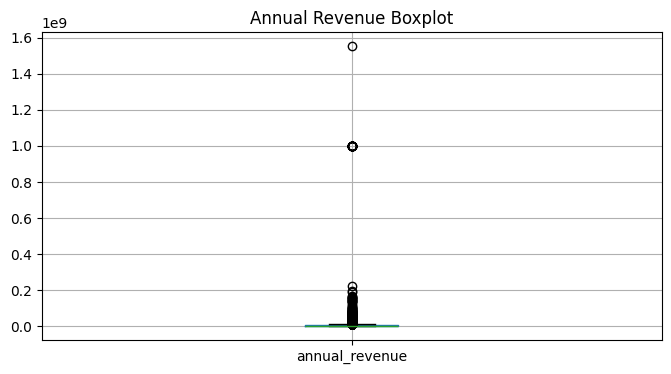

In [16]:

plt.figure(figsize=(8, 4))
df.boxplot(column='annual_revenue')
plt.title("Annual Revenue Boxplot")
plt.show()

#### IQR Method

In [17]:
Q1 = df['annual_revenue'].quantile(0.25)
Q3 = df['annual_revenue'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[df['annual_revenue'] > upper_bound]
outliers_count = outliers.shape[0]

print(f"Revenue > upper bound: {upper_bound:,.0f}")
print(f"Outlier count: {outliers_count}")
outliers[['company_name', 'annual_revenue']]

Revenue > upper bound: 11,960,459
Outlier count: 1045


,company_name,annual_revenue
17,Ortiz Ltd,1.988227e+07
18,"Sanders, Miller and Murphy",1.226964e+07
22,"Pugh, Henderson and Moon",2.763819e+07
41,Mendoza Group,1.505715e+07
53,Stone Group,1.380875e+07
...,...,...
9924,Brewer Inc,2.436462e+07
9938,Ellison PLC,1.426374e+07
9956,Pollard and Sons,1.000000e+09
9960,Gomez and Sons,2.247226e+07


#### Revenue Outlier Summary

- Using the IQR method, over **1,000 outliers** were identified in `annual_revenue`.

- Upper bound for normal range ≈ **$11.9M**

- Business-rule violations include:
  - **Negative revenue** → invalid → set to `0`
  - **Revenue > $500M** → cap at **$500M**

### 7. Duplicate Emails Handling

In [19]:
# Identify duplicated contact_email values
duplicate_emails = df[df.duplicated(subset='contact_email', keep=False)]

# Show only lead_id and contact_email for these duplicates
duplicate_emails_sorted = duplicate_emails[['lead_id', 'contact_email','contact_phone']].sort_values(by='contact_email')
duplicate_emails_sorted

,lead_id,contact_email,contact_phone
5553,6b3a3e7d-9a67-436b-9b95-be9f083faea2,aaron25@example.org,6646227643 extension 789
2706,120928e1-1b24-48b0-a51d-dbca998aae24,aaron25@example.org,None
1729,0d6aaa35-b737-40ba-b8a0-aa4f4db7aec1,aaronthompson@example.org,(297)339-6707x106 x123
4771,ad6d1ef8-3e9b-4869-b143-c5766ceee7c2,aaronthompson@example.org,+1-948-623-2204x144
8921,b202ebc0-9662-4e75-9858-b7743d360bcf,aclark@example.org,+1-830-825-3216x718
...,...,...,...
6249,423fadca-0d7c-43fa-96fb-16cea8f58797,zanderson@example.org,824.897.0730
5630,5f63c2bd-acdd-44d3-906a-f30193a5fbb4,zjones@example.org,None
9060,bd5fd1c9-480b-4c0b-9830-47b8fbec31d4,zjones@example.org,350-901-8421
954,6a4b0a8f-0434-4cec-a95a-20e3bdf1de4e,zryan@example.net,None


#### Duplicate Email Addresses Detected

- Although `lead_id` is unique, some leads share the same `contact_email`.
- In some cases, one record has a phone number while the other does not.
- This duplication can lead to double-counting in funnel conversion, revenue per lead, or engagement analysis.
- ** Keep only one lead per unique email address ( based on date)

#  Contact Events Table Analysis
Understanding data quality issues before building the `stg_contact_events` staging model.

In [12]:
df_ce.head()

,event_id,lead_id,event_date,contact_type,response_type
0,bc29197a-59c8-4369-826b-52e7c0fd08e4,002ce5fb-d808-451a-b709-638cbb8550d2,2024-04-17,Email,No Response
1,26f23ce7-ad0c-4ab2-ae68-82f8d161d6cb,002ce5fb-d808-451a-b709-638cbb8550d2,2024-04-20,Phone Call,No Response
2,c8d29c26-d59c-4b78-b373-8422d0488ec7,002ce5fb-d808-451a-b709-638cbb8550d2,2024-05-04,LinkedIn Message,No Response
3,af123e4e-927e-4172-b8b4-10d9d888fe65,53b14edc-b37f-4f74-afbe-46a4ef7a7c2e,2024-05-19,Email,Responded
4,a6511c2a-8f37-4ddb-8512-69caabf82e94,53b14edc-b37f-4f74-afbe-46a4ef7a7c2e,2024-05-24,Demo Request,No Response


#### Check for Nulls and Data Types

In [15]:
df_ce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35921 entries, 0 to 35920
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   event_id       35921 non-null  object
 1   lead_id        35921 non-null  object
 2   event_date     35921 non-null  object
 3   contact_type   35921 non-null  object
 4   response_type  33825 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


Observation:
- Table has 35,921 rows and 5 columns.
- `response_type` has 2,096 missing values.

### 1. Check for missing values in response_type

In [23]:
df_ce['response_type'].value_counts(dropna=False)

response_type
No Response           20296
Responded              6242
Interested             3723
Callback Requested     2486
None                   2096
                       1078
Name: count, dtype: int64

In [25]:
df_ce['response_type'].isnull().sum()

np.int64(2096)

Observation:
- 2,096 values are null in `response_type`.
- Another 1,078 rows contain empty string `''` or "None" as string.
- We’ll normalize all missing or non-meaningful responses as `"No Response"` in the staging model.

### 2. Check contact_type formatting issues

In [26]:
df_ce['contact_type'].value_counts(dropna=False)

contact_type
Email               11995
Phone Call           8793
LinkedIn Message     6261
Demo Request         6006
demo request          800
email                 789
call                  383
phone call            361
linkedin              269
LinkedIn              264
Name: count, dtype: int64

Observation:
- There are casing issues (e.g., 'email', 'Email', 'PHONE CALL') and inconsistent spellings ('linkedin', 'LinkedIn').
- These will be standardized using `.strip().title()` and mapped to canonical types in staging.

# Funnel Stages Table Analysis
Reviewing data quality issues to inform our staging logic for `stg_funnel_stages`.

In [29]:
df_fs.head()

,stage_id,lead_id,stage_name,stage_date,stage_order
0,1849eac1-41f6-47b1-8778-383a80e824db,002ce5fb-d808-451a-b709-638cbb8550d2,Contacted,2024-04-17,2.0
1,a3a4fdfb-d306-4091-bcb7-7a566a2636cb,002ce5fb-d808-451a-b709-638cbb8550d2,Qualified,2024-04-26,3.0
2,14027d65-5d48-41df-adc8-94d6f9790c44,002ce5fb-d808-451a-b709-638cbb8550d2,demo scheduled,2024-04-18,4.0
3,51c84aae-07db-4963-85ec-3ce92563183c,002ce5fb-d808-451a-b709-638cbb8550d2,Proposal Sent,2024-04-26,5.0
4,d1f5c519-5511-4a69-9bf1-bc3a1adf32b5,53b14edc-b37f-4f74-afbe-46a4ef7a7c2e,Contacted,2024-05-18,2.0


####  Check for Nulls and Data Types

In [28]:
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20145 entries, 0 to 20144
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stage_id     20145 non-null  object 
 1   lead_id      20145 non-null  object 
 2   stage_name   20145 non-null  object 
 3   stage_date   20145 non-null  object 
 4   stage_order  19843 non-null  float64
dtypes: float64(1), object(4)
memory usage: 787.0+ KB


#### 1. Check for missing or invalid stage_order

The `stage_order` column is expected to hold values from 1 to 7, representing the standard progression through the sales funnel.

Let’s check for missing and out-of-range values.

In [31]:
df_fs['stage_order'].value_counts(dropna=False).sort_index()

stage_order
-5.0       96
-1.0       99
 0.0      100
 2.0     5563
 3.0     5010
 4.0     4059
 5.0     3018
 6.0     1696
 8.0      109
 99.0      93
 NaN      302
Name: count, dtype: int64

Observation:
- 302 records have missing `stage_order` (NaN).
- Several entries have invalid values:
  - Negative values: -5.0 (96), -1.0 (99)
  - Zero value: 0.0 (100)
  - Out-of-range high values: 8.0 (109), 99.0 (93)
    
- These need to be fixed in the staging layer:
  - Invalid values will be corrected or mapped using `stage_name`.
  - Records that cannot be resolved logically may be flagged or dropped.

#### 2. Explore Records with Invalid Stage Order

In [40]:
# Also check for stage orders outside expected range (1 to 7)
invalid_stage_orders = df_fs[(df_fs['stage_order'] < 1) | (df_fs['stage_order'] > 7)]
invalid_stage_orders[['lead_id', 'stage_order', 'stage_name']].head()

,lead_id,stage_order,stage_name
12,111e6929-f1a3-4dbf-81c4-6934ae1946a0,99.0,Qualified
57,a5ab82b4-a109-445d-a8cd-6501483e2ea8,-1.0,mql
123,9fd533ac-b084-4f34-9422-616a7d77de28,99.0,contacted
142,8690d62a-5af6-44d6-b3af-8d85c9de4a2c,-1.0,Proposal Sent
158,5679dcbe-9ad8-439f-8a32-d78694cf50d3,-1.0,Demo Scheduled


Sample Issues:
- `stage_order` values like 99.0 or -1.0 are clearly placeholders or errors.
- These entries still have meaningful `stage_name` values like “Qualified” or “Proposal Sent”.
- We will use these `stage_name` values to assign the correct order during staging transformation.

#### 3. Check for inconsistent stage_name values

In [34]:
df_fs['stage_name'].value_counts(dropna=False)

stage_name
Contacted              5317
Qualified              4804
Demo Scheduled         3891
Proposal Sent          2880
Closed Won             1641
contacted               469
demo                    173
mql                     147
demo scheduled          147
marketing qualified     146
qualified               140
quote sent               93
proposal                 90
quote                    79
closed won               50
closed-won               43
won                      35
Name: count, dtype: int64

Observation:
- Multiple variations exist for the same logical stage:
  - 'Qualified', 'qualified'
  - 'Demo Scheduled', 'demo scheduled', 'demo'
  - 'Proposal Sent', 'quote sent', 'proposal', 'quote'
  - 'Closed Won', 'closed won', 'closed-won', 'won'
- These inconsistencies will be standardized in the staging model using title case and mapping logic.

#### 4. Missing stage_order entries

In [35]:
df_fs[df_fs['stage_order'].isnull()][['lead_id', 'stage_name']].head()

,lead_id,stage_name
67,337e0cc0-c398-4f88-97a3-b8cb7565b408,Demo Scheduled
136,fbf463f5-fe9c-4fc9-8708-dfa73d9da9d9,Demo Scheduled
144,47c382b3-22c8-464c-8bb5-d5389d45da89,Contacted
182,e8e7eea7-0a4c-4bef-9a1f-85823ef557d7,demo scheduled
360,e5d2a4d6-c2e9-4562-a0b5-e083e6c7b99f,Demo Scheduled


Observation:
- Some records (e.g., 'Demo Scheduled', 'Contacted', 'demo scheduled') are missing `stage_order`.
- These will be mapped to correct values based on stage name in staging.
- If `stage_name` is not mappable, we may drop or flag them during transformation.

# 4. Outcomes Table Analysis
Identifying key data quality issues to guide our staging logic for `stg_outcomes.sql`.

#### 1. Preview of `outcomes` Table

In [43]:
df_out.head()

,outcome_id,lead_id,converted,revenue,outcome_date,days_to_close
0,ec0da8ae-5cd2-47d8-a757-a97019a6c772,8d2d1774-db4f-4dc1-bc00-a9726ec8f9d8,1,31010.071131,2024-09-02,121
1,7781fcd3-e512-4361-9728-3c8eeaaf96de,2ce56e80-c4a1-47e3-aabf-9ee6d7eb6399,1,95859.744954,2024-03-26,3
2,3dcfe9d8-5166-49ea-bd49-d9d071dade73,c254ffba-0a9a-485d-a5d4-7113e75211ce,1,28320.469325,2024-03-16,11
3,30785f67-1398-4a14-addf-83aac53c917c,a5ab82b4-a109-445d-a8cd-6501483e2ea8,1,63652.674582,2024-02-28,39
4,cb9c1451-d839-43ac-8fbc-dcbd29cc7b87,337e0cc0-c398-4f88-97a3-b8cb7565b408,1,30496.124536,2024-07-29,79


**Observation:**
- The table includes key outcome-related fields: `converted`, `revenue`, `outcome_date`, and `days_to_close`.
- Revenue values contain **up to 6 decimal places** — these will be **rounded to 2 decimals** in staging.
- All shown leads are marked as converted (1), which should be boolean.
- `outcome_date` format looks consistent — we’ll validate further for nulls or future values.
- We'll also validate if the days to close values are within a **reasonable range** (e.g., not negative or beyond 730 days).

#### 2. Check for Nulls and Data Types

In [44]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377 entries, 0 to 3376
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   outcome_id     3377 non-null   object 
 1   lead_id        3377 non-null   object 
 2   converted      3377 non-null   int64  
 3   revenue        3377 non-null   float64
 4   outcome_date   3366 non-null   object 
 5   days_to_close  3377 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 158.4+ KB


**Observation:**
- There are **3377 rows** in the dataset.
- `outcome_date` has **11 missing values**, which should be handled appropriately in staging (e.g., set to current date for converted leads).
- Other columns (`converted`, `revenue`, `days_to_close`) have **no missing values**.
- Data types look valid for now, but we’ll investigate further for:
  - Revenue outliers (negative or extreme values)
  - Negative or unrealistic `days_to_close`

#### 3. Revenue Distribution Summary

In [47]:
df_out['revenue'].describe()

count    3.377000e+03
mean     2.580705e+06
std      4.870234e+07
min     -7.956850e+04
25%      0.000000e+00
50%      2.009105e+04
75%      4.087317e+04
max      1.000000e+09
Name: revenue, dtype: float64

 **Observation:**

- **Negative revenue detected** (min: -79,568.50) — must be capped at **0.00**.

- **Extreme outliers present**:
  - Mean is $2.58M, but median is just ~$20K — heavily skewed.
  - Max value hits **$1B**, clearly unrealistic for CRM revenue.

- Majority of revenue values are small (75% under ~$41K).

- In staging:
  - Set **negative revenue to 0.00**.
  - Cap high revenue (e.g., >$500K or $2M) to a more realistic threshold like **$500K**.
  - Round values to **2 decimal places**.

#### 4. Negative Revenue Count

In [48]:
# Count negative revenue
neg_revenue_count = (df_out['revenue'] < 0).sum()
neg_revenue_count

np.int64(21)

**Observation:**
- Found **21 records** with negative revenue values.

#### 5. Extreme Revenue Outliers

In [49]:
# Count extreme revenue outliers
high_revenue_count = (df_out['revenue'] > 2_000_000).sum()
high_revenue_count

np.int64(33)

**Observation:**
- Detected **33 records** with revenue over **$2,000,000**.

-  We will **cap them to $500,000** in the staging model to prevent skewed metrics.

#### 6. Common Test Revenue Values

In [50]:
# View common test values
df_out['revenue'].value_counts().head(10)

revenue
0.000000e+00    1587
5.000000e+04      28
2.500000e+06      13
5.000000e+07      12
1.000000e+09       8
5.922603e+04       1
9.743671e+04       1
4.356605e+04       1
7.958235e+04       1
3.399171e+04       1
Name: count, dtype: int64

**Observation:**

- **$0 revenue** appears in **1587** records — likely unconverted or invalid leads.
  
- Placeholder/test values such as **$2.5M**, **$50M**, and **$1B** are also frequent.

#### 7. Days to Close — Negative or Unrealistic Durations
The `days_to_close` metric should always be non-negative and realistically within 2 years.
Let’s validate the range.

In [51]:
# Check for negatives and extremely high values
df_out['days_to_close'].describe()

count    3377.000000
mean       61.388214
std       109.221630
min      -134.000000
25%        20.000000
50%        49.000000
75%        83.000000
max      1500.000000
Name: days_to_close, dtype: float64

**Observation:**
  
- **Negative values** like -134 are not valid; we’ll **convert these to positive** in staging.
- Some records have extremely large values like **1500 days**, which is over **4 years**.

#### 8. Check for Negative Days to Close

In [53]:
# Count invalid values
neg_days = (df_out['days_to_close'] < 0).sum()
neg_days

np.int64(66)

- `66` records have **negative** `days_to_close`, which should be converted to **positive** values.

#### 9 Check for Extremely Long Sales Cycles

In [54]:
extreme_days = (df_out['days_to_close'] > 730).sum()
extreme_days

np.int64(34)

- `34` records have `days_to_close` values **above 730 days**, which will be **capped at 730** (2 years).

#### 10. Missing Outcome Dates for Converted Leads
Converted leads should always have a `conversion_date`. Let’s check for any missing.

In [66]:
# Filter converted leads where outcome_date is missing
missing_outcome_dates = df_out[(df_out['converted'] == True) & (df_out['outcome_date'].isnull())]
missing_outcome_count = missing_outcome_dates.shape[0]
missing_outcome_count

11

- `11` converted leads are **missing `outcome_date`**. These will be **set to the current date** in staging to maintain timeline consistency.

#### 11. Revenue Present but Not Converted

In [58]:
# Revenue present but not converted
df_out[(df_out['converted'] == False) & (df_out['revenue'] > 0)].shape[0]


44

- `44` leads show revenue even though they are marked as not converted → may indicate data entry or business logic inconsistency.

#### 12 Outcome Date Present but Not Converted

In [61]:
# Conversion date exists but not converted
df_out[(df_out['converted'] == False) & (df_out['outcome_date'].notnull())].shape[0]

1608

- `1608` leads have outcome dates but are marked as not converted → outcome logic may need review.